In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [3]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        
        self.deconv1_1 = nn.ConvTranspose2d(nz, ngf*4, 3, 1, 0, bias=False)
        self.deconv1_1_bn =  nn.BatchNorm2d(ngf*4)
        self.relu1_1 = nn.ReLU(True)
        self.deconv1_2 = nn.ConvTranspose2d(10, ngf*4, 3, 1, 0, bias=False)
        self.deconv1_2_bn =  nn.BatchNorm2d(ngf*4)
        self.relu1_2 = nn.ReLU(True)

        self.main = nn.Sequential(
            #ngf*3*3
            nn.ConvTranspose2d(ngf*8, ngf*2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            #ngf*2*7*7
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #ngf*14*14
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            #1*28*28
        )
    def forward(self, x, label):
        x = self.relu1_1(self.deconv1_1_bn(self.deconv1_1(x)))
        y = self.relu1_2(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x,y],1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        #1*28*28
        self.conv1_1 = nn.Conv2d(1, ndf, 4, 2, 1, bias=False)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(10, ndf, 4, 2, 1, bias=False)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.main = nn.Sequential(
            #ngf*14*14
            nn.Conv2d(ndf*2, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            #ngf*2*7*7
            nn.Conv2d(ndf*2, ndf*4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            #ngf*2*7*7
            nn.Conv2d(ndf*4, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
            #3*28*28
            
        )
    def forward(self, x, label):
        x = self.lrelu1_1(self.conv1_1(x))
        y = self.lrelu1_2(self.conv1_2(label))
        x = torch.cat([x,y], 1)
        return self.main(x).squeeze()


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
#Conditional GAN

# Constants
EPOCH_NUM = 10
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 8
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))])

train_dl, test_dl, _ = create_dataloader('MNIST', transform, valid=False)

nz = 100
ngf = 128
ndf = 128
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()

optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

G_loss_list, D_loss_list = [], []
best_loss_G, best_loss_D = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
fill = torch.zeros([10, 10, 28, 28])
for i in range(10):
    fill[i, i, :, :] = 1
onehot, fill = onehot.to(device), fill.to(device)

for epoch in range(EPOCH_NUM):
    D_x, D_G_z1, D_G_z2 = 0, 0, 0
    iter_num = 0

    for datas, labels in train_dl:
        iter_num += 1
        real_img = datas.to(device)
        real_label = onehot[labels]
        img_num = real_img.size(0)

        noise = torch.randn(img_num, nz, 1, 1, device=device)
        rand_label = (torch.rand(img_num, 1) * 10).type(torch.LongTensor).squeeze()
        fake_label = onehot[rand_label]
        fake_fill = fill[rand_label]

        real_target = torch.full((img_num,), 1., device=device)
        fake_target = torch.full((img_num,), 0., device=device)

        real_fill = fill[labels]
        #########################################
        netD.zero_grad()

        logits_real = netD(real_img, real_fill)
        loss_real = criterion(logits_real, real_target)
        D_x = logits_real.mean().item()

        fake_img = netG(noise, fake_label)
        logits_fake = netD(fake_img.detach(), fake_fill)
        loss_fake = criterion(logits_fake, fake_target)
        D_G_z1 = logits_fake.mean().item()            

        loss_D = loss_real + loss_fake
        D_loss_list.append(loss_D.item())

        loss_D.backward()
        optim_D.step()
        
        ####################################
        netG.zero_grad()

        noise = torch.randn(img_num, nz, 1, 1, device=device)
        rand_label = (torch.rand(img_num, 1) * 10).type(torch.LongTensor).squeeze()
        fake_label = onehot[rand_label]
        fake_fill = fill[rand_label]

        fake_img = netG(noise, fake_label)
        logits_fake_G = netD(fake_img, fake_fill)
        loss_G = criterion(logits_fake_G, real_target)
        D_G_z2 = logits_fake_G.mean().item()
        G_loss_list.append(loss_G.item())

        loss_G.backward()
        optim_G.step()
        
        ####################################
        if iter_num%200 == 0:
            print('EPOCH:{:}, iter:{:}, loss_D={:.3}, loss_G={:.3}, D(x)={:.3}, D(G(z))={:.3}/{:.3}'.format(epoch, iter_num, loss_D, loss_G, D_x, D_G_z1, D_G_z2))
        if epoch==0 or best_loss_D >= loss_D:
            best_loss_D = loss_D
        if epoch==0 or best_loss_G >= loss_G:
            best_loss_G = loss_G
    
print('Best loss_D={:.3} Best loss_G={:.3}'.format(best_loss_D, best_loss_G))


EPOCH:0, iter:200, loss_D=0.18, loss_G=2.96, D(x)=0.934, D(G(z))=0.1/0.0602
EPOCH:0, iter:400, loss_D=0.21, loss_G=2.76, D(x)=0.878, D(G(z))=0.0571/0.0762
EPOCH:0, iter:600, loss_D=0.466, loss_G=3.99, D(x)=0.846, D(G(z))=0.189/0.0273
EPOCH:0, iter:800, loss_D=0.503, loss_G=2.04, D(x)=0.722, D(G(z))=0.0577/0.198
EPOCH:1, iter:200, loss_D=1.05, loss_G=2.17, D(x)=0.655, D(G(z))=0.357/0.192
EPOCH:1, iter:400, loss_D=1.15, loss_G=0.907, D(x)=0.478, D(G(z))=0.191/0.455
EPOCH:1, iter:600, loss_D=0.996, loss_G=1.94, D(x)=0.581, D(G(z))=0.267/0.188
EPOCH:1, iter:800, loss_D=0.953, loss_G=1.09, D(x)=0.539, D(G(z))=0.214/0.379
EPOCH:2, iter:200, loss_D=1.59, loss_G=1.06, D(x)=0.394, D(G(z))=0.398/0.389
EPOCH:2, iter:400, loss_D=0.99, loss_G=1.2, D(x)=0.576, D(G(z))=0.31/0.335
EPOCH:2, iter:600, loss_D=0.991, loss_G=1.93, D(x)=0.696, D(G(z))=0.428/0.17
EPOCH:2, iter:800, loss_D=1.31, loss_G=1.41, D(x)=0.489, D(G(z))=0.381/0.27
EPOCH:3, iter:200, loss_D=1.59, loss_G=1.56, D(x)=0.56, D(G(z))=0.589/0

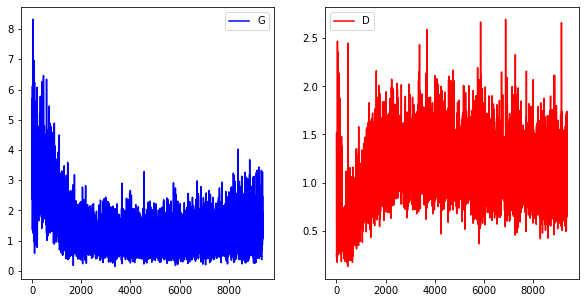

In [6]:

fig = plt.figure(figsize=(10.0, 5.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(G_loss_list, 'b', label='G')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.plot(D_loss_list, 'r', label='D')
ax2.legend()
plt.show()

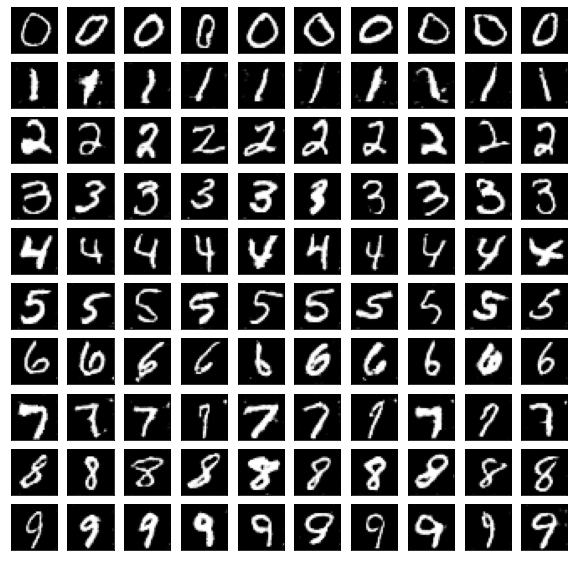

In [14]:
fig = plt.figure(figsize=(10.0, 10.0))
for i in range(10):
    fixed_noise = torch.randn(10, nz, 1, 1, device=device)
    rand_label = (torch.ones(10, 1) * i).type(torch.LongTensor).squeeze()
    fake_label = onehot[rand_label]
    img = netG(fixed_noise,fake_label)
    for j, img in enumerate(img.squeeze().cpu().detach().numpy()):
        ax = fig.add_subplot(10,10,i*10+j+1,xticks=[], yticks=[])
        ax.imshow(img,cmap='binary_r')